In [1]:
import os
import math
import numpy as np
import pandas as pd
from typing import Iterable, List
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Transformer
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from Constants import *

In [2]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
CONTEXT_LANGUAGE = 'en'
TARGET_LANGUAGE = 'fr'

token_transform = {}
vocab_transform = {}

In [4]:
token_transform[CONTEXT_LANGUAGE] = get_tokenizer('spacy', language = 'en_core_web_sm')
token_transform[TARGET_LANGUAGE] = get_tokenizer('spacy', language = 'fr_core_news_sm')

In [5]:
data.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [6]:
training_set, testing_set = train_test_split(data, test_size = 0.2)

In [38]:
# Custom Dataset_Loader

class Dataset_Loader(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return(
            self.data["English words/sentences"].iloc[idx],
            self.data["French words/sentences"].iloc[idx]
        )

In [39]:
train_set = Dataset_Loader(training_set)
validation_set = Dataset_Loader(testing_set)

iterator = iter(train_set)
print(next(iterator))

('He has no real friends.', "Il n'a aucun véritable ami.")


In [40]:
# Generating tokens

def get_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {CONTEXT_LANGUAGE: 0, TARGET_LANGUAGE: 1}
    
    for text_sample in data_iter:
        yield token_transform[language](text_sample[language_index[language]])
        
# Sentence tokens
UNKNOWN_INDEX, PAD_INDEX, START_INDEX, END_INDEX = 0, 1, 2, 3
standin_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for line in [CONTEXT_LANGUAGE, TARGET_LANGUAGE]:
    vocab_transform[line] = build_vocab_from_iterator(get_tokens(train_set, line),
                                                      min_freq = 1,
                                                      specials = standin_symbols,
                                                      special_first = True,)
    
# Unkown_index as default index
for line in [CONTEXT_LANGUAGE, TARGET_LANGUAGE]:
    vocab_transform[line].set_default_index(UNKNOWN_INDEX)

In [41]:
def sequential_transforms(*transforms):
    def func(text_input):
        for transform in transforms:
            text_input = transform(text_input)
        
        return text_input
    return func

def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([START_INDEX]),
                      torch.tensor(token_ids),
                      torch.tensor([END_INDEX])))


# Convert strings to tensor
text_transform = {}
for line in [CONTEXT_LANGUAGE, TARGET_LANGUAGE]:
    text_transform[line] = sequential_transforms(token_transform[line],
                                                 vocab_transform[line],
                                                 tensor_transform)
    
    
# Getting tokenized context and target batches
def collate_fn(batch):
    context_batch, target_batch = [], []
    for context_sample, target_sample in batch:
        context_batch.append(text_transform[CONTEXT_LANGUAGE](context_sample.rstrip("\n")))
        target_batch.append(text_transform[TARGET_LANGUAGE](target_sample.rstrip("\n")))
        
    context_batch = pad_sequence(context_batch, padding_value = PAD_INDEX, batch_first = True)
    target_batch  = pad_sequence(target_batch,  padding_value = PAD_INDEX, batch_first = True)
    
    return context_batch, target_batch

In [42]:
CONTEXT_VOCAB_SIZE = len(vocab_transform[CONTEXT_LANGUAGE])
TARGET_VOCAB_SIZE = len(vocab_transform[TARGET_LANGUAGE])
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
# Generate masks for context and target snetences

def generate_subsequent_mask(size):
    mask = (torch.triu(torch.ones((size, size), device = DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    
    return mask

def generate_mask(context, target):
    context_sequence_len = context.shape[1]
    target_sequence_len  =  target.shape[1]
    
    target_mask = generate_subsequent_mask(target_sequence_len)
    context_mask = torch.zeros((context_sequence_len, context_sequence_len), device = DEVICE).type(torch.bool)
    
    context_padding_mask = (context == PAD_INDEX)
    target_padding_mask = (target == PAD_INDEX)
    
    return context_mask, target_mask, context_padding_mask, target_padding_mask

In [44]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p = dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        
        return self.dropout(x)

In [45]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [46]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, 
                 num_encoding_layers: int,
                 num_decoding_layers: int,
                 emb_size: int,
                 nhead: int,
                 context_vocab_size: int,
                 target_vocab_size: int,
                 feed_forward_dim: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model = emb_size,
                                       nhead = nhead,
                                       num_encoder_layers = num_encoding_layers,
                                       num_decoder_layers = num_decoding_layers,
                                       dim_feedforward = feed_forward_dim,
                                       dropout = dropout,
                                       batch_first = True)
        self.generator = nn.Linear(emb_size, target_vocab_size)
        self.context_token_emb = TokenEmbedding(context_vocab_size, emb_size)
        self.target_token_emb = TokenEmbedding(target_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size,
                                                      dropout = dropout)
        
    def forward(self,
                context: Tensor,
                target: Tensor,
                context_mask: Tensor,
                target_mask: Tensor,
                context_padding_mask: Tensor,
                target_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        context_emb = self.positional_encoding(self.context_token_emb(context))
        target_emb  = self.positional_encoding(self.target_token_emb(target))
        outs = self.transformer(context_emb,
                                target_emb,
                                context_mask,
                                target_mask,
                                None,
                                context_padding_mask,
                                target_padding_mask,
                                memory_key_padding_mask)
        
        return self.generator(outs)
    
    def encode(self, context: Tensor, context_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(self.context_token_emb(context)), context_mask)
    
    def decode(self, target: Tensor, memory: Tensor, target_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(self.target_token_emb(target)), memory, target_mask)

In [47]:
model = Seq2SeqTransformer(NUM_ENCODING_LAYERS,
                           NUM_ENCODING_LAYERS,
                           EMBEDDING_SIZE,
                           NUM_MULTIHEAD,
                           CONTEXT_VOCAB_SIZE,
                           TARGET_VOCAB_SIZE,
                           FEED_FWD_DIMENSION).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} trainable parameters.")
print(model)

13,961,528 parameters.
13,961,528 trainable parameters.
Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
          )
          (linear1): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=192, out_features=192, bias=True)
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x Transfo

In [48]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index = PAD_INDEX)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, betas = (0.9, 0.98), eps = 1e-9)

In [49]:
train_dataloader = DataLoader(train_set, batch_size = BATCH_SIZE, collate_fn = collate_fn)
def train_epoch(model, optimizer):
    print("Training")
    model.train()
    losses = 0
    
    for context, target in tqdm(train_dataloader, total = len(list(train_dataloader))):
        context = context.to(DEVICE)
        target = target.to(DEVICE)
        
        target_input = target[:, :-1]
        
        context_mask, target_mask, context_padding_mask, target_padding_mask = generate_mask(context, target_input)
        
        logits = model(context,
                       target_input,
                       context_mask,
                       target_mask,
                       context_padding_mask,
                       target_padding_mask,
                       context_padding_mask)
        
        optimizer.zero_grad()
        
        target_out = target[:, 1:]
        loss = loss_fn(logits.view(-1, TARGET_VOCAB_SIZE), target_out.contiguous().view(-1))
        loss.backward()
        
        optimizer.step()
        losses += loss.item()
        
    return losses / len(list(train_dataloader))

val_dataloader = DataLoader(validation_set, batch_size = BATCH_SIZE, collate_fn = collate_fn)
def evaluate(model):
    print("Validating")
    model.eval()
    losses = 0
    
    for context, target in tqdm(val_dataloader, total = len(list(val_dataloader))):
        context = context.to(DEVICE)
        target = target.to(DEVICE)
        
        target_input = target[:, :-1]
        
        context_mask, target_mask, context_padding_mask, target_padding_mask = generate_mask(context, target_input)
        
        logits = model(context,
                       target_input,
                       context_mask,
                       target_mask,
                       context_padding_mask,
                       target_padding_mask,
                       context_padding_mask)
        
        target_out = target[:, 1:]
        loss = loss_fn(logits.view(-1, TARGET_VOCAB_SIZE), target_out.contiguous().view(-1))
        losses += loss.item()
        
    return losses / len(list(val_dataloader))

In [19]:
train_loss_list, validation_loss_list = [], []
for epoch in range(1, EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    validation_loss = evaluate(model)
    end_time = timer()
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)
    #print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {validation_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s\n"))
    print(f"Training loss: {train_loss:.3f}")
    print(f"Validation loss: {validation_loss:.3f}")
    print(f"Epoch time = {(end_time - start_time):.3f}s\n")
    print("~ " * 100)

Training


  0%|          | 0/732 [00:00<?, ?it/s]

c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\torch\nn\functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 1, Train loss: 5.499, Val loss: 4.246, Epoch time = 4722.172s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 2, Train loss: 4.033, Val loss: 3.626, Epoch time = 5125.410s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 3, Train loss: 3.566, Val loss: 3.275, Epoch time = 4442.342s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 4, Train loss: 3.270, Val loss: 3.028, Epoch time = 3914.915s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 5, Train loss: 3.054, Val loss: 2.841, Epoch time = 4487.301s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 6, Train loss: 2.880, Val loss: 2.677, Epoch time = 4573.078s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 7, Train loss: 2.730, Val loss: 2.538, Epoch time = 3908.004s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 8, Train loss: 2.599, Val loss: 2.419, Epoch time = 3912.613s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 9, Train loss: 2.483, Val loss: 2.316, Epoch time = 5250.067s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 10, Train loss: 2.382, Val loss: 2.225, Epoch time = 3946.458s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 11, Train loss: 2.290, Val loss: 2.144, Epoch time = 4065.798s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 12, Train loss: 2.207, Val loss: 2.074, Epoch time = 3940.878s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 13, Train loss: 2.136, Val loss: 2.011, Epoch time = 3911.640s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 14, Train loss: 2.069, Val loss: 1.955, Epoch time = 3936.840s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 15, Train loss: 2.009, Val loss: 1.909, Epoch time = 3864.362s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 16, Train loss: 1.953, Val loss: 1.864, Epoch time = 3856.012s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 17, Train loss: 1.902, Val loss: 1.824, Epoch time = 3914.101s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 18, Train loss: 1.856, Val loss: 1.786, Epoch time = 3937.932s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 19, Train loss: 1.811, Val loss: 1.755, Epoch time = 3863.078s

Training


  0%|          | 0/732 [00:00<?, ?it/s]

Validating


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch: 20, Train loss: 1.773, Val loss: 1.724, Epoch time = 4048.614s



In [20]:
def save_plots(train_loss, validation_loss):
    plt.figure(figsize = (10, 8))
    plt.plot(train_loss, label = 'Train loss')
    plt.plot(validation_loss, label = 'Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join("../outputs", "loss.png"))
    plt.show()

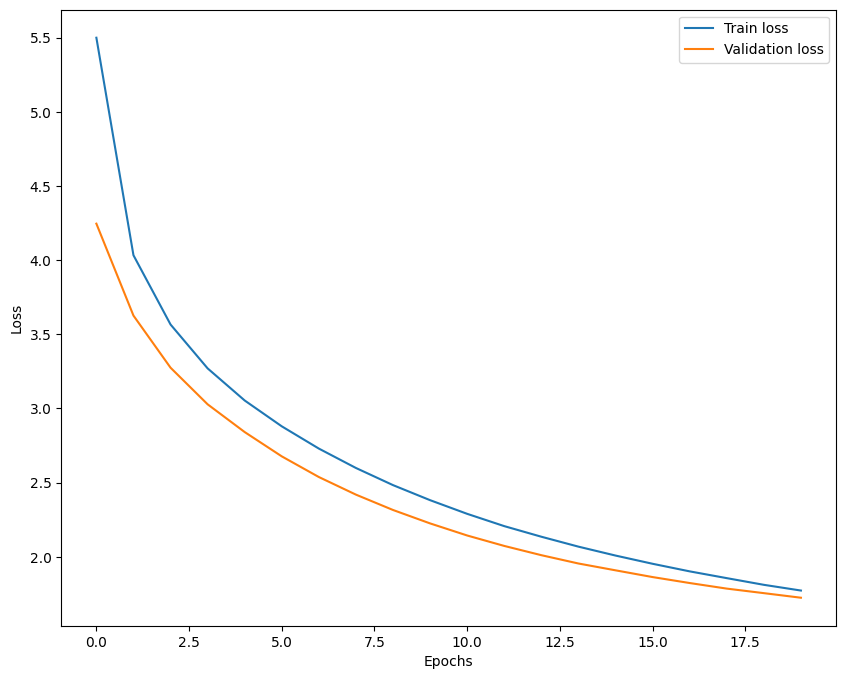

In [21]:
save_plots(train_loss_list, validation_loss_list)

In [22]:
torch.save(model, "../outputs/model.pth")

In [50]:
model = torch.load('../outputs/model.pth')

In [51]:

def greedy_decode(model, context, context_mask, max_len, start_symbol):
    context = context.to(DEVICE)
    context_mask = context_mask.to(DEVICE)
    memory = model.encode(context, context_mask)
    y_pred = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len - 1):
        memory = memory.to(DEVICE)
        if i == 0:
            y_pred = y_pred.transpose(1, 0)
        target_mask = (generate_subsequent_mask(y_pred.size(1))
                       .type(torch.bool)).to(DEVICE)
        out = model.decode(y_pred, memory, target_mask)
        out = out
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        y_pred = torch.cat([y_pred, torch.ones(1, 1).type_as(context.data).fill_(next_word)], dim = 1)
        if next_word == END_INDEX:
            break
        
    return y_pred

def translate(model: torch.nn.Module, context_sentence: str):
    model.eval()
    context = text_transform[CONTEXT_LANGUAGE](context_sentence).view(1, -1)
    num_tokens = context.shape[1]
    context_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    target_tokens = greedy_decode(model,
                                  context,
                                  context_mask,
                                  max_len = num_tokens + 5, 
                                  start_symbol = START_INDEX).flatten()

    return " ".join(vocab_transform[TARGET_LANGUAGE].lookup_tokens(list(target_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [59]:
sample_sentences = [
    ["It's bright outside today!", "Il est brillant a l'exterieur aujourd'hui!"],
    ["Don't forget to dehydrate.", "N'oubliez pas de deshydrater"],
    ["I'll see you again tomorrow.", "Je te reverrai demain"],
    ["What time is it?", "Quelle heure est-il?"],
    ["This translation model is not bad.", "Ce modele de traduction n'est pas mauvais"],
    ["Happy holidays to all who celebrate.", "Bonnes acances a tous ceux quix celebrent"]
]
for sentence in sample_sentences:
    print(f"Context: {sentence[0]}")
    print(f"Actual: {sentence[1]}")
    print(f"Predicted: {translate(model, sentence[0])}\n")

Context: It's bright outside today!
Actual: Il est brillant a l'exterieur aujourd'hui!
Predicted:  C' est désormais aujourd'hui   ! 

Context: Don't forget to dehydrate.
Actual: N'oubliez pas de deshydrater
Predicted:  N' oublie pas de oublier . 

Context: I'll see you again tomorrow.
Actual: Je te reverrai demain
Predicted:  Je te verrai demain . 

Context: What time is it?
Actual: Quelle heure est-il?
Predicted:  À quelle heure est -il ? 

Context: This translation model is not bad.
Actual: Ce modele de traduction n'est pas mauvais
Predicted:  Ce n' est pas mauvais . 

Context: Happy holidays to all who celebrate.
Actual: Bonnes acances a tous ceux quix celebrent
Predicted:  Les gens qui sont tous à l' intérieur . 

